In [3]:
import os
import shutil

# Define the source directory (where the subfolders are)
source_dir = '/Users/rajdipingale/Downloads/archive (15)/images_128_128'

# Define the destination directory (where all images will be moved)
destination_dir = '/Users/rajdipingale/Downloads/archive (15)/train'

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Iterate through all subfolders and move images to the destination folder
for subdir, dirs, files in os.walk(source_dir):
    for file in files:
        # Check if the file is an image by extension (add more extensions if necessary)
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
            # Construct the full file path
            file_path = os.path.join(subdir, file)
            
            # Move the file to the destination directory
            shutil.move(file_path, destination_dir)

print("All images have been moved to:", destination_dir)


All images have been moved to: /Users/rajdipingale/Downloads/archive (15)/train


Found 105100 files belonging to 1 classes.


2024-10-04 11:28:52.812683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3285/3285 [==============================] - 901s 274ms/step - total_loss: 0.0420 - reconstruction_loss: 0.0391 - kl_loss: 0.0029


2024-10-04 11:43:54.504460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 13ms/step


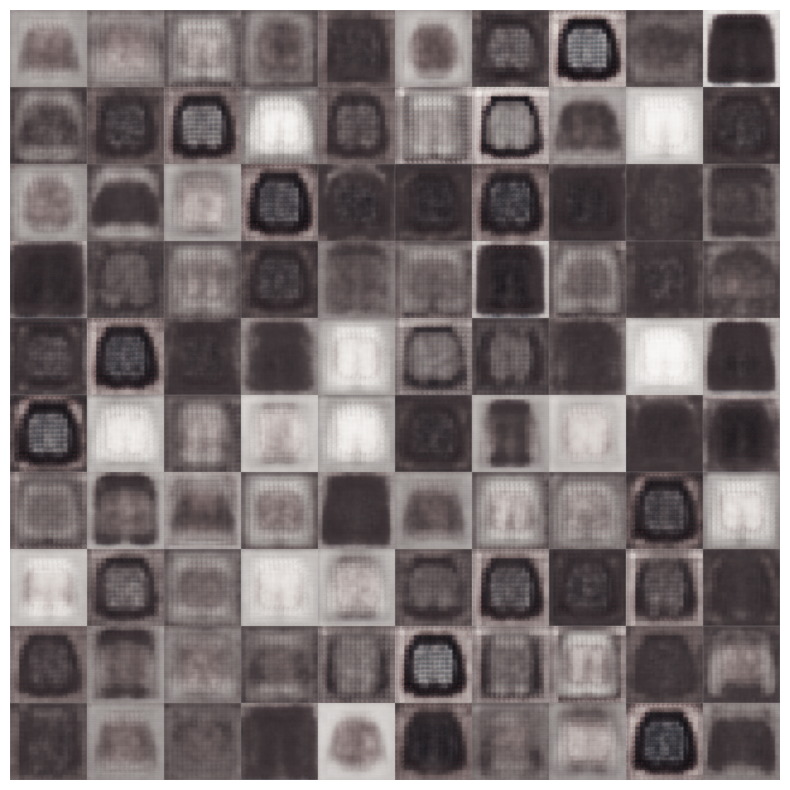

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from PIL import Image

# Load images from local directory
def load_image_dataset(data_dir, img_size=(128, 128), batch_size=1024):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        label_mode=None,  # No labels needed for VAE
        image_size=img_size,
        batch_size=batch_size
    )
    return dataset

# Load your dataset (assuming this function exists)
data_dir = '/Users/rajdipingale/Downloads/archive (15)/train'
img_size = (128, 128)  # Your image size
batch_size = 32  # Adjust batch size as needed
train_dataset = load_image_dataset(data_dir, img_size=img_size, batch_size=batch_size)

# Define a function to normalize images
def normalize_image(image):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image

# Apply the normalization function to the dataset
train_dataset = train_dataset.map(normalize_image)

# Define the latent space dimension
latent_dim = 512

# VAE encoder network for RGB images (128x128)
encoder_inputs = keras.Input(shape=(128, 128, 3))
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)  # 64x64x32
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)  # 32x32x64
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)  # Latent space mean
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)  # Latent space log variance
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name='encoder')

# Sampler
class Sampler(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Sampler()([z_mean, z_log_var])

# VAE decoder network for RGB images (with fixed output size of 128x128)
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(16 * 16 * 128, activation='relu')(latent_inputs)  # Starting size: 16x16x128
x = layers.Reshape((16, 16, 128))(x)  # Reshape the latent vector
x = layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(x)  # Output: 32x32x128
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)   # Output: 64x64x64
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)   # Output: 128x128x32
decoder_outputs = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)  # Output: 128x128x3
decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')




# VAE model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = keras.metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = keras.metrics.Mean(name='kl_loss')

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler([z_mean, z_log_var])
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            'total_loss': self.total_loss_tracker.result(),
            'reconstruction_loss': self.reconstruction_loss_tracker.result(),
            'kl_loss': self.kl_loss_tracker.result(),
        }

# Create and train the VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(train_dataset, epochs=1, batch_size=1024)

# After training, you can generate new images from the latent space
n = 10  # Number of images per row/column in the grid
figure = np.zeros((128 * n, 128 * n, 3), dtype=np.uint8)

grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.random.normal(size=(1, latent_dim))  # Sample from latent space
        x_decoded = vae.decoder.predict(z_sample)  # Generate an image from the latent vector
        digit = (x_decoded[0] * 255).astype(np.uint8)  # Rescale to 8-bit RGB
        figure[i * 128: (i + 1) * 128, j * 128: (j + 1) * 128, :] = digit  # Place in the grid

# Create a plot to display the generated RGB images
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.axis("off")
plt.show()
